In [87]:
import numpy as np
import pandas as pd
import os,cv2,gc
import pickle
from tqdm.notebook import tqdm
from collections import OrderedDict
import h5py
import random
import torch
from sklearn.model_selection import KFold,StratifiedKFold
import tifffile
import timm
from torchvision import transforms
from sklearn import metrics
from torch.utils.data import Dataset, DataLoader
from scipy.stats import binned_statistic
from pathlib import Path
import matplotlib.pyplot as plt
import random
from copy import copy
%matplotlib inline

In [2]:
TEST = '../data/test'

In [13]:
def extract_data_from_hdf5(path):
    data = {}
    with h5py.File(path, "r") as f:
        ID_key =  path.stem
        # Retrieve the frequency data
        #data['freq'] = np.array(f[ID_key]['frequency_Hz'])
        # Retrieve the Livingston decector data
        data['L1_SFTs_amplitudes'] = np.array(f[ID_key]['L1']['SFTs'])
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])
        # Retrieve the Hanford decector data
        data['H1_SFTs_amplitudes'] = np.array(f[ID_key]['H1']['SFTs'])
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
    return data

In [4]:
from pdb import set_trace

In [5]:
class G2NetDataset_hdf5(Dataset):
    def __init__(self, path=TEST, sz_f=352, sz_t=128):
        self.files = [
            os.path.join(path, f)
            for f in os.listdir(path)
            if f.split(".")[-1] == "hdf5"
        ]
        self.sz_t, self.sz_f = sz_t, sz_f
        self.tfrms = transforms.CenterCrop((sz_f, sz_t))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = extract_data_from_hdf5(self.files[idx])
        time_ids = {"H1": data["H1_ts"], "L1": data["L1_ts"]}
        mean_statH = binned_statistic(
            time_ids["H1"],
            np.abs(data["H1_SFTs_amplitudes"] * 1e22) ** 2,
            statistic="mean",
            bins=self.sz_t,
            range=(
                max(time_ids["H1"].min(), time_ids["L1"].min()),
                min(time_ids["H1"].max(), time_ids["L1"].max()),
            ),
        )
        mean_statL = binned_statistic(
            time_ids["L1"],
            np.abs(data["L1_SFTs_amplitudes"] * 1e22) ** 2,
            statistic="mean",
            bins=self.sz_t,
            range=(
                max(time_ids["H1"].min(), time_ids["L1"].min()),
                min(time_ids["H1"].max(), time_ids["L1"].max()),
            ),
        )
        mean_statH = np.nan_to_num(np.transpose(mean_statH.statistic, (0, 1)))
        mean_statL = np.nan_to_num(np.transpose(mean_statL.statistic, (0, 1)))

        x = torch.from_numpy(np.stack([mean_statH, mean_statL], 0).astype(np.float32))
        x = self.tfrms(x)
        c, h, w = x.shape
        x[0] /= torch.max(x[0].mean(0, keepdim=True), 0.1 * torch.ones_like(x[0]))
        x[1] /= torch.max(x[1].mean(0, keepdim=True), 0.1 * torch.ones_like(x[1]))
        x = torch.cat([x, 0.5 * (x[0] + x[1]).unsqueeze(0)], 0)
        idx = self.files[idx].split("/")[-1].split(".")[0]
        return x
    
    
class G2NetDataset_hdf5(Dataset):
    def __init__(self, path=TEST, sz_f=352, sz_t=128):
        self.files = real_noise_fns + fake_noise_fns
        self.sz_t, self.sz_f = sz_t, sz_f
        self.tfrms = transforms.CenterCrop((sz_f, sz_t))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = extract_data_from_hdf5(self.files[idx])
        time_ids = {"H1": data["H1_ts"], "L1": data["L1_ts"]}
        mean_statH = binned_statistic(
            time_ids["H1"],
            np.abs(data["H1_SFTs_amplitudes"] * 1e22) ** 2,
            statistic="mean",
            bins=self.sz_t,
            range=(
                max(time_ids["H1"].min(), time_ids["L1"].min()),
                min(time_ids["H1"].max(), time_ids["L1"].max()),
            ),
        )
        mean_statL = binned_statistic(
            time_ids["L1"],
            np.abs(data["L1_SFTs_amplitudes"] * 1e22) ** 2,
            statistic="mean",
            bins=self.sz_t,
            range=(
                max(time_ids["H1"].min(), time_ids["L1"].min()),
                min(time_ids["H1"].max(), time_ids["L1"].max()),
            ),
        )
        mean_statH = np.nan_to_num(np.transpose(mean_statH.statistic, (0, 1)))
        mean_statL = np.nan_to_num(np.transpose(mean_statL.statistic, (0, 1)))

        x = torch.from_numpy(np.stack([mean_statH, mean_statL], 0).astype(np.float32))
        x = self.tfrms(x)
        c, h, w = x.shape
        x[0] /= torch.max(x[0].mean(0, keepdim=True), 0.1 * torch.ones_like(x[0]))
        x[1] /= torch.max(x[1].mean(0, keepdim=True), 0.1 * torch.ones_like(x[1]))
        x = torch.cat([x, 0.5 * (x[0] + x[1]).unsqueeze(0)], 0)
        return x

In [ ]:
ds = G2NetDataset_hdf5()

In [ ]:
test_stats = []
for i in tqdm(ds):
    test_stats.append({"min_value": i.min(), "max_value": i.max()})

In [6]:
signal = list(Path('../data/custom_data/SIGNAL_V0/data/').glob('*.pth')) + list(Path('../data/custom_data/SIGNAL_V1/data/').glob('*.pth')) 

In [180]:
real_noise_fns = sorted(
    Path("../data/custom_data/DATA_V33/data/").glob("*.h5"),
    key=lambda x: str(x).split("_")[-2],
)

fake_noise_fns = sorted(
    Path("../data/custom_data/DATA_V34/data/").glob("*.h5"),
    key=lambda x: str(x).split("_")[-2],
)


noise = (
    list(Path("../data/custom_data/DATA_V31_V32_NOISE").glob("*.h5"))
    + real_noise_fns[:1100]
    + fake_noise_fns
)

<AxesSubplot:ylabel='Frequency'>

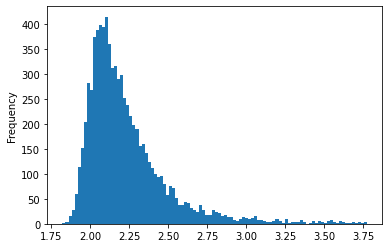

In [181]:
pd.read_csv('test_statistics.csv').sort_values(by='max_value')['max_value'][:-200].plot.hist(bins=100)

In [182]:
len(signal)

6310

In [183]:
def normalize(data, sz_t=128):     
    time_ids = {"H1": data["H1_ts"], "L1": data["L1_ts"]}
    mean_statH = binned_statistic(
        time_ids["H1"],
        np.abs(data["H1_SFTs_amplitudes"] * 1e22) ** 2,
        statistic="mean",
        bins=sz_t,
        range=(
            max(time_ids["H1"].min(), time_ids["L1"].min()),
            min(time_ids["H1"].max(), time_ids["L1"].max()),
        ),
    )
    mean_statL = binned_statistic(
        time_ids["L1"],
        np.abs(data["L1_SFTs_amplitudes"] * 1e22) ** 2,
        statistic="mean",
        bins=sz_t,
        range=(
            max(time_ids["H1"].min(), time_ids["L1"].min()),
            min(time_ids["H1"].max(), time_ids["L1"].max()),
        ),
    )
    mean_statH = np.nan_to_num(np.transpose(mean_statH.statistic, (0, 1)))
    mean_statL = np.nan_to_num(np.transpose(mean_statL.statistic, (0, 1)))

    x = torch.from_numpy(np.stack([mean_statH, mean_statL], 0).astype(np.float32))
    c, h, w = x.shape
    x[0] /= torch.max(x[0].mean(0, keepdim=True), 0.1 * torch.ones_like(x[0]))
    x[1] /= torch.max(x[1].mean(0, keepdim=True), 0.1 * torch.ones_like(x[1]))
    #x = torch.cat([x, 0.5 * (x[0] + x[1]).unsqueeze(0)], 0)
    return x

In [184]:
def combine(sig_, noise, w=1):
    sig = copy(sig_)
    min_value_l= min(sig['L1_SFTs_amplitudes'].shape[1], noise['L1_SFTs_amplitudes'].shape[1])
    min_value_h= min(sig['H1_SFTs_amplitudes'].shape[1], noise['H1_SFTs_amplitudes'].shape[1])
    sig['L1_SFTs_amplitudes'] = w * sig['L1_SFTs_amplitudes'][:, :min_value_l] + noise['L1_SFTs_amplitudes'][:, :min_value_l]
    sig['H1_SFTs_amplitudes'] = w * sig['H1_SFTs_amplitudes'][:, :min_value_h] + noise['H1_SFTs_amplitudes'][:, :min_value_h]
    sig['H1_ts'] = sig['H1_ts'][:min_value_h]
    sig['L1_ts'] = sig['L1_ts'][:min_value_l]
    return sig

In [197]:
sig = torch.load(signal[0])
#nos = extract_data_from_hdf5(random.choice(noise))

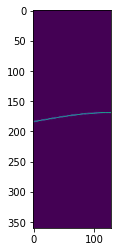

In [177]:
plt.imshow(normalize(sig).mean(0))

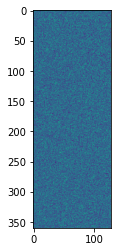

In [178]:
plt.imshow(normalize(nos).mean(0))

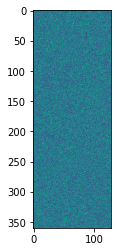

In [179]:
out = normalize(combine(sig, nos))
plt.imshow(out.mean(0))

In [174]:
sig.keys()

dict_keys(['L1_SFTs_amplitudes', 'H1_SFTs_amplitudes', 'H1_ts', 'L1_ts', 'freq'])